In [5]:
import numpy as np
import os
from glob import glob
import sys
from PIL import Image
import gc
import matplotlib.pyplot as plt

In [8]:
!rm -fr *
!7z x /kaggle/input/litstumorprep/tumor-masks.zip > /dev/null

In [9]:
%pip install -q segmentation-models-pytorch

Note: you may need to restart the kernel to use updated packages.


In [55]:
import torch
from torch import nn, optim
from torch.utils.data import *
from torchvision import transforms
import torchmetrics

import segmentation_models_pytorch as smp
import pytorch_lightning as pl

In [27]:
class TumorDataset(Dataset):
    def __init__(self, root):
        self.root = root
        self.images = glob(f'{root}/tumor-images/*.png')
        self.masks = [m.replace('images', 'masks') for m in self.images]
        
        size = (224, 224)
        self.img_transform = transforms.Compose([
            transforms.Resize(size),
            transforms.ToTensor(),
        ])
        
        self.mask_transform = transforms.Compose([
            transforms.Resize(size),
            transforms.ToTensor(),
        ])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        mask = Image.open(self.masks[idx])
        
        return self.img_transform(image), self.mask_transform(mask)

In [28]:
dataset = TumorDataset('.')

In [49]:
train_size = int(0.8 * len(dataset))
val_size   = int(0.1 * len(dataset))
test_size  = len(dataset) - train_size - val_size

batch_size = 10

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3)
val_loader = DataLoader(val_ds, batch_size, shuffle=False, num_workers=3)
test_loader = DataLoader(test_ds, batch_size, shuffle=False, num_workers=3)

In [122]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        return 1 - dice

In [134]:
class LitsModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = smp.UnetPlusPlus(
            encoder_name='efficientnet-b5',
            encoder_weights=None,
            in_channels=1,
            activation='sigmoid'
        )
        
        self.criterion = DiceLoss()
        
    def forward(self, x):
        return self.model(x)
    
    def dice(self, outputs, truth):
        return torchmetrics.functional.dice(
            outputs,
            truth.long()
        )
    
    def training_step(self, batch):
        inputs, truth = batch
        outputs = self(inputs)
        
        loss = self.criterion(outputs, truth)
        self.log('loss/train', loss.item(), prog_bar=True)
        self.log('epoch/loss/train', loss.item(), prog_bar=True, on_epoch=True)
        # self.log('dice/train', self.dice(outputs, truth), prog_bar=True)
        
        return loss
    
    def test_step(self, batch):
        inputs, truth = batch
        outputs = self(inputs)
        
        loss = self.criterion(outputs, truth)
        self.log('loss/test', loss.item())
        self.log('dice/test', self.dice(outputs, truth), prog_bar=True)
    
    def validation_step(self, batch):
        inputs, truth = batch
        outputs = self(inputs)
        
        loss = self.criterion(outputs, truth)
        self.log('loss/val', loss.item(), prog_bar=True)
        self.log('epoch/loss/val', loss.item(), prog_bar=True, on_epoch=True)
        self.log('dice/val', self.dice(outputs, truth), prog_bar=True)
        
    def configure_optimizers(self):
        return optim.RMSprop(self.parameters(), lr=1e-4)
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        inputs, _ = batch
        return self(inputs)

In [135]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

model = LitsModel()

In [161]:
trainer = pl.Trainer(
    max_epochs=5,
    max_time={'hours': 3},
#     limit_train_batches=100,
#     limit_val_batches=1,
#     limit_test_batches=1,
    enable_checkpointing=False
)

In [162]:
trainer.fit(model, train_loader, val_loader)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [163]:
predictions = trainer.predict(model, test_loader)

predictions2 = torch.cat(predictions).cpu().squeeze()
predictions2.shape

Predicting: |          | 0/? [00:00<?, ?it/s]

torch.Size([1917, 224, 224])

In [165]:
masks = [mask for inputs, mask in test_loader]
images = [img for img, _ in test_loader]

masks2 = torch.cat(masks).squeeze().cpu()
images2 = torch.cat(images).squeeze().cpu()

In [166]:
scores = {}
for th in np.arange(0.6, 1.1, 0.1):
    score = (
        torchmetrics.functional.dice(
            predictions2, masks2.long(),
            threshold=th
        )
    )
    
    scores[th] = score
scores

{0.6: tensor(0.7914),
 0.7: tensor(0.7937),
 0.7999999999999999: tensor(0.7964),
 0.8999999999999999: tensor(0.8001),
 0.9999999999999999: tensor(0.8172),
 1.0999999999999999: tensor(0.)}

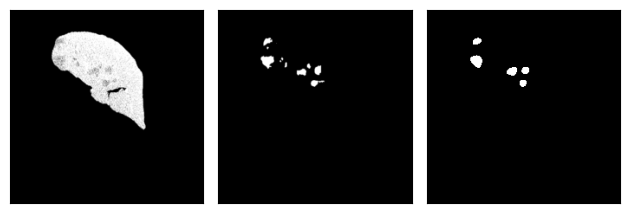

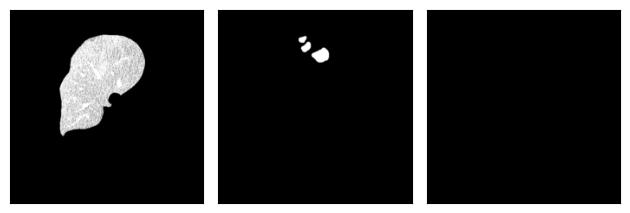

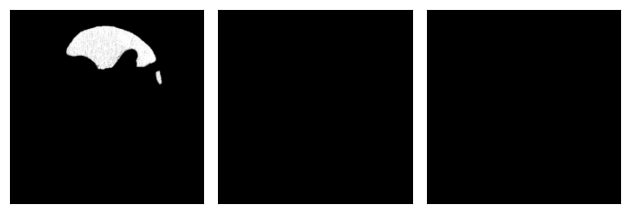

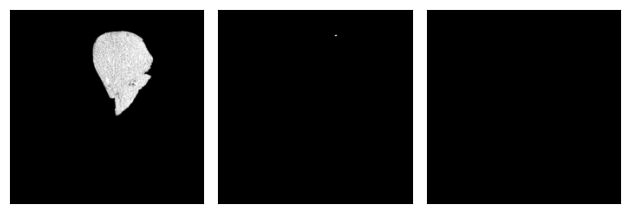

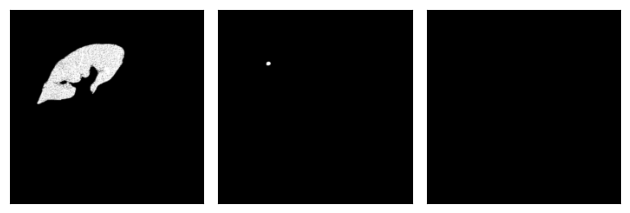

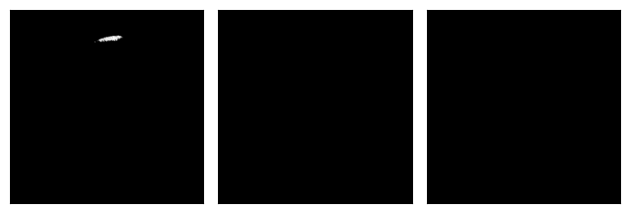

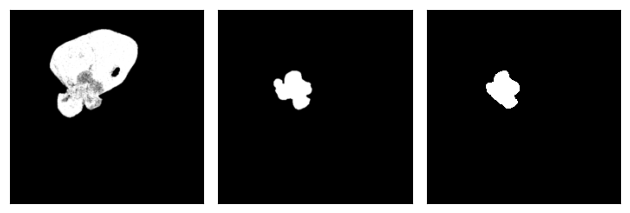

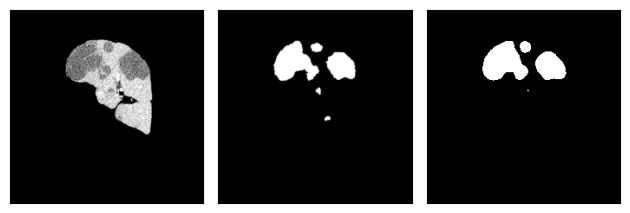

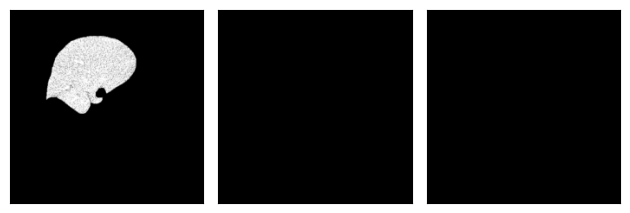

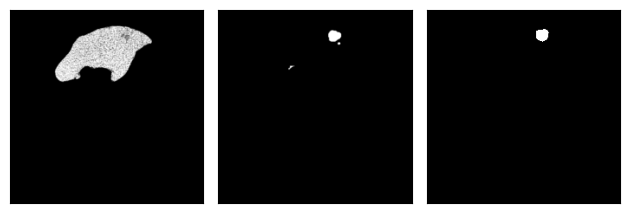

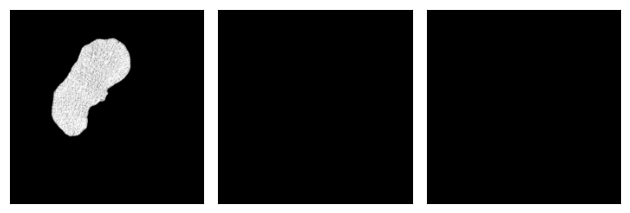

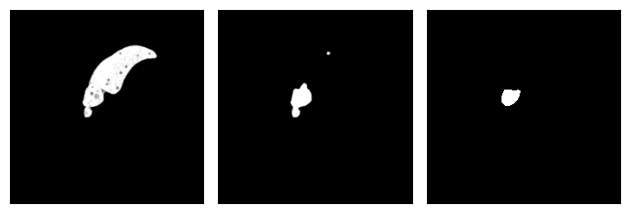

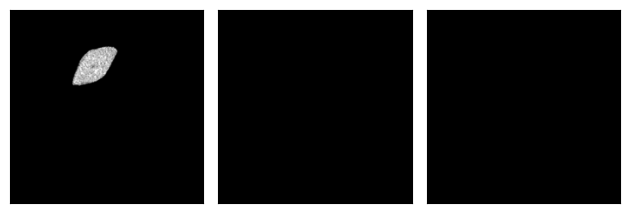

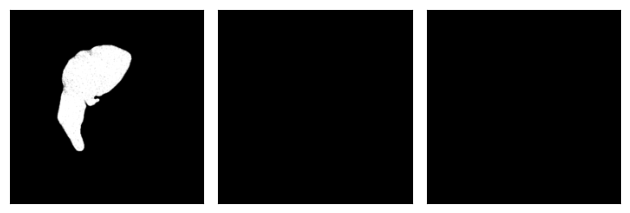

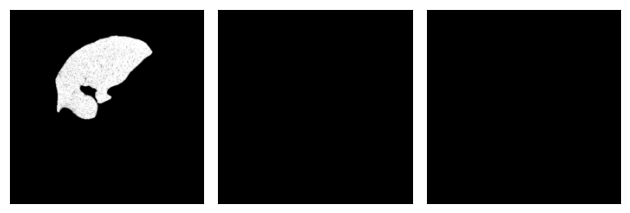

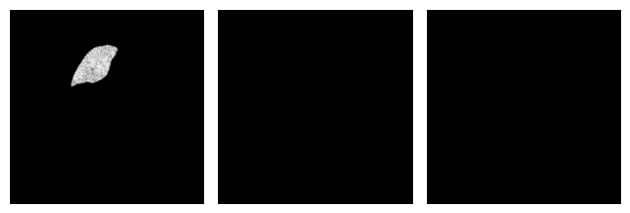

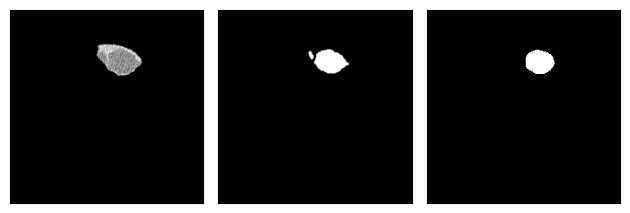

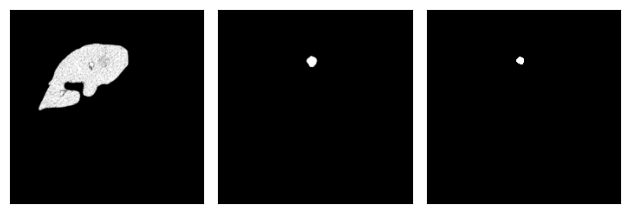

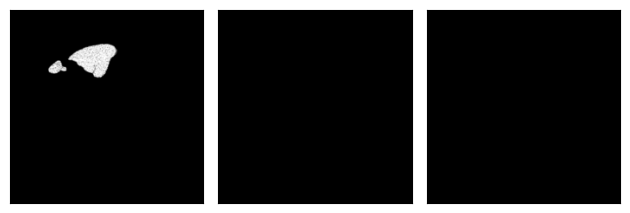

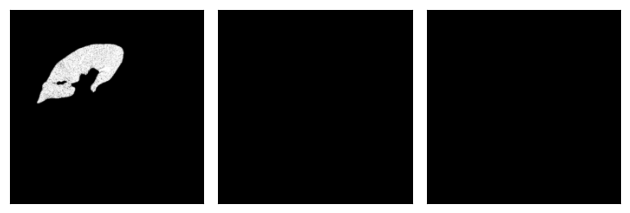

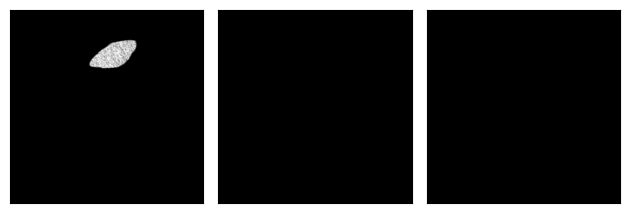

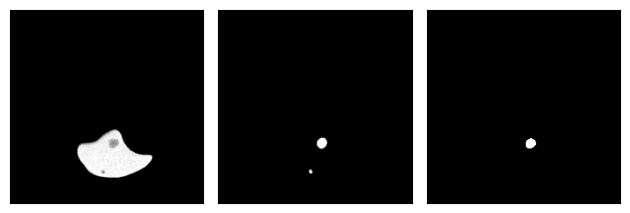

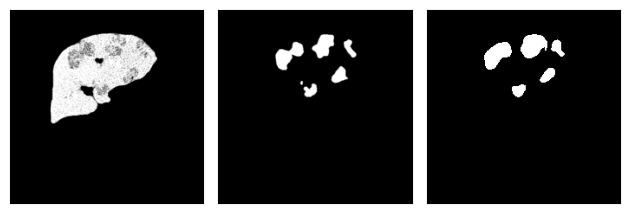

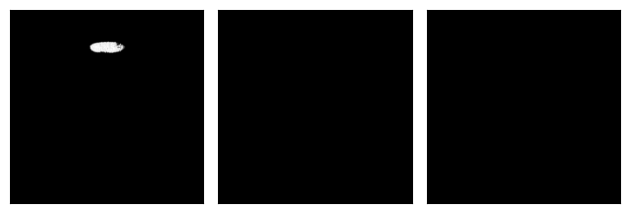

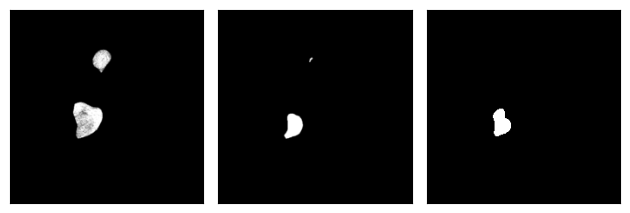

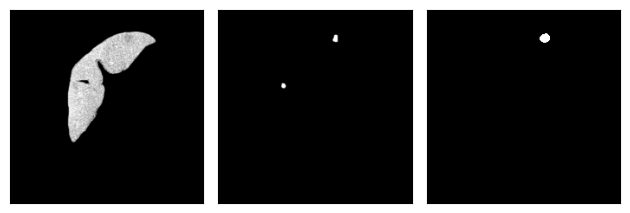

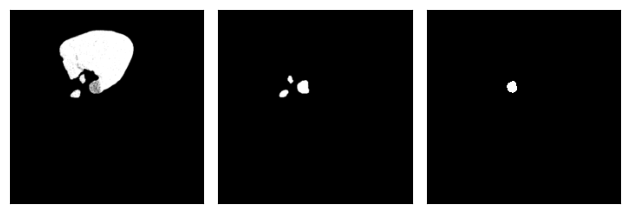

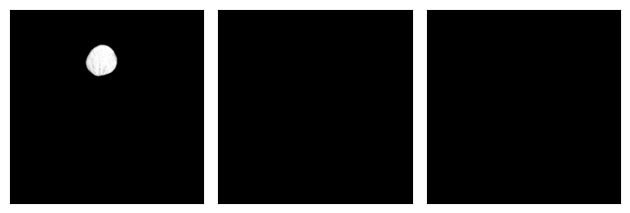

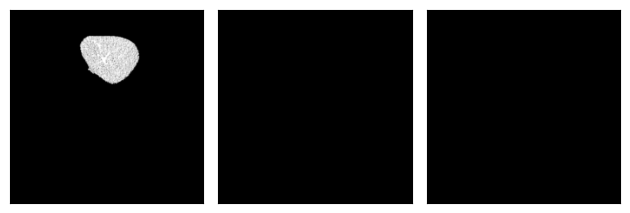

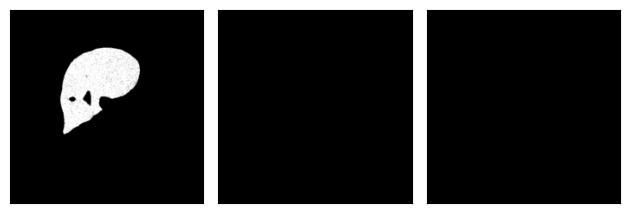

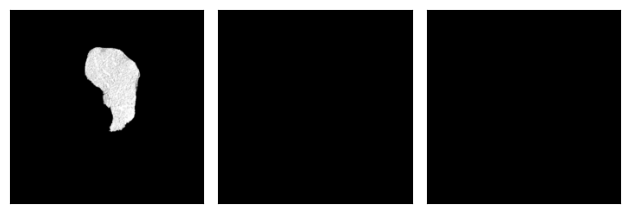

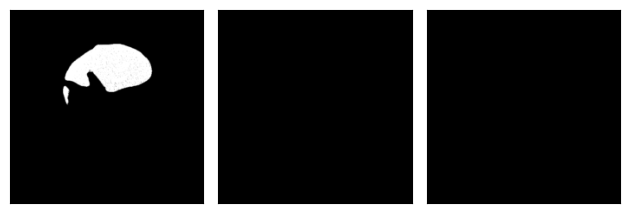

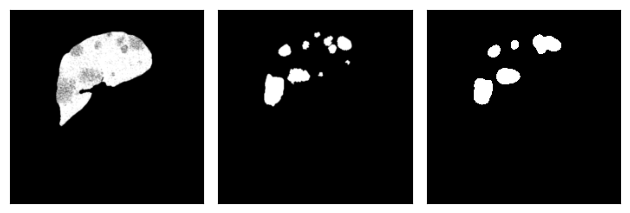

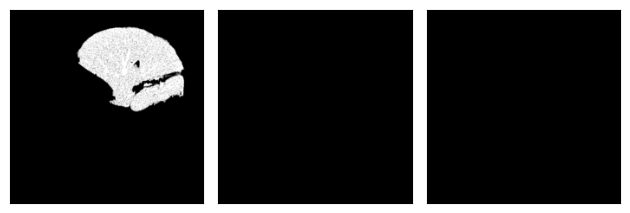

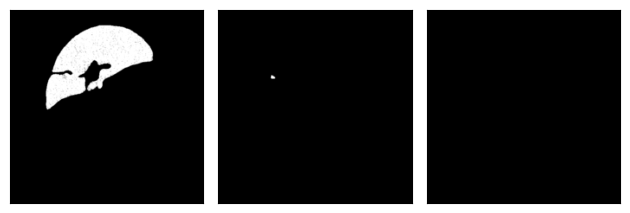

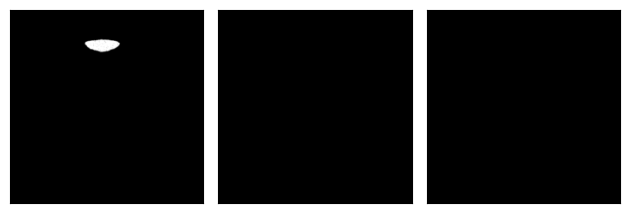

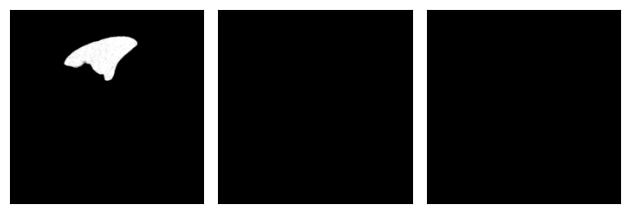

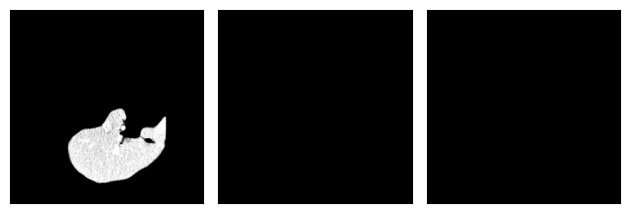

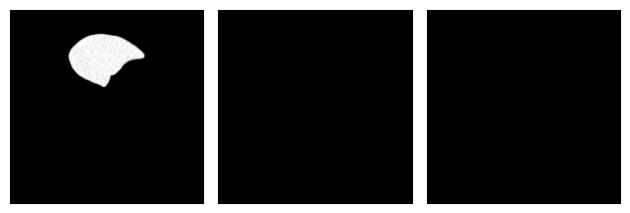

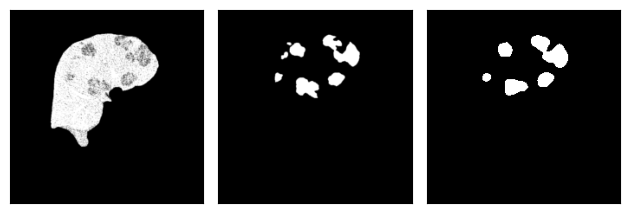

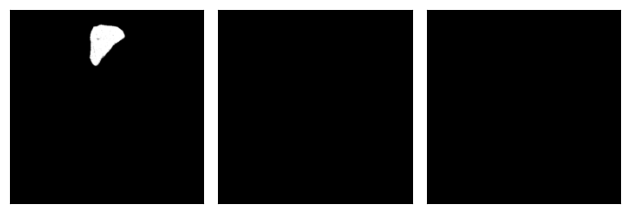

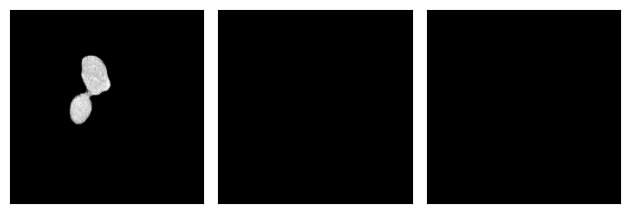

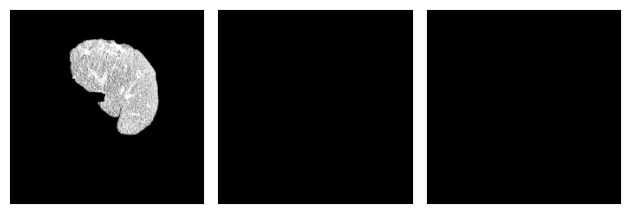

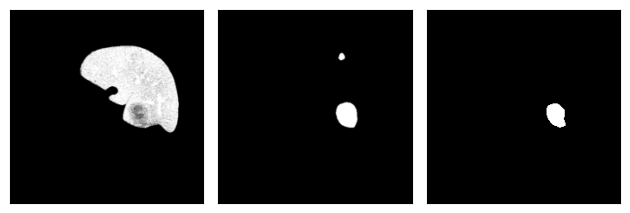

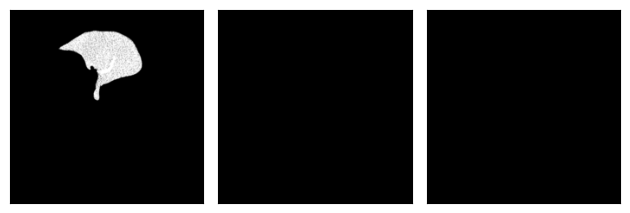

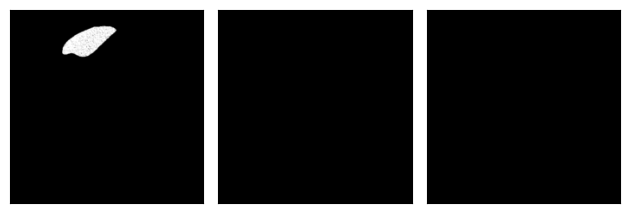

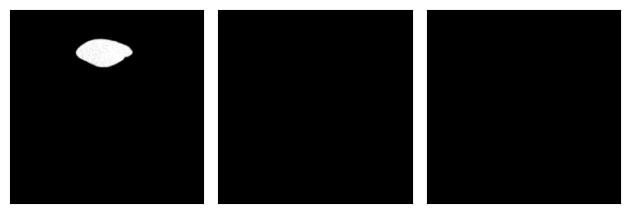

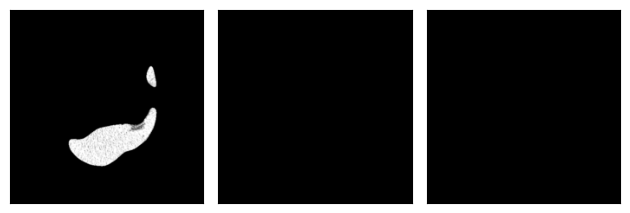

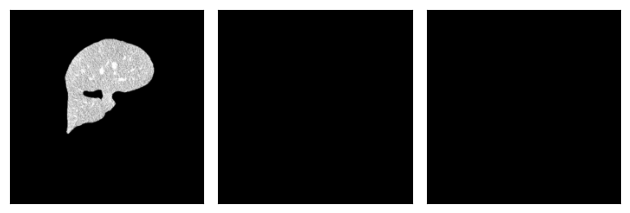

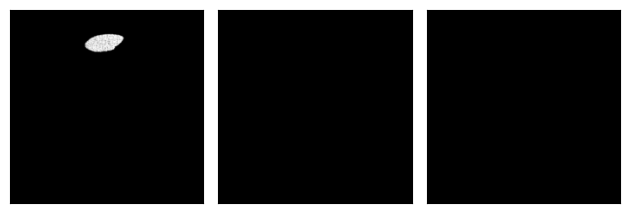

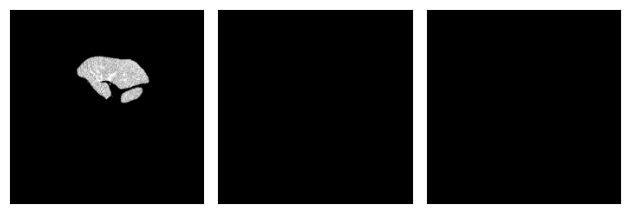

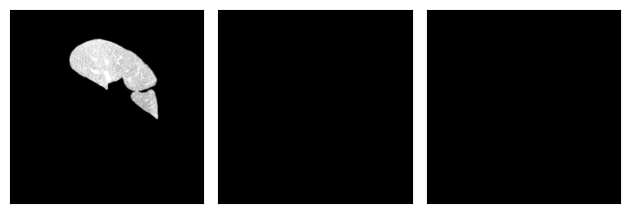

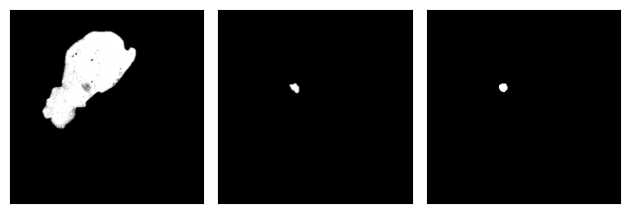

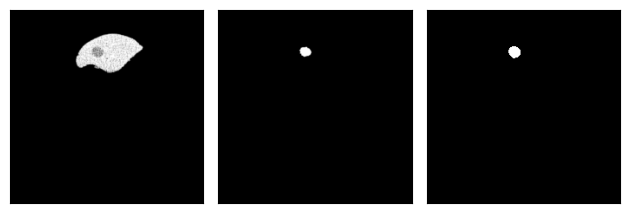

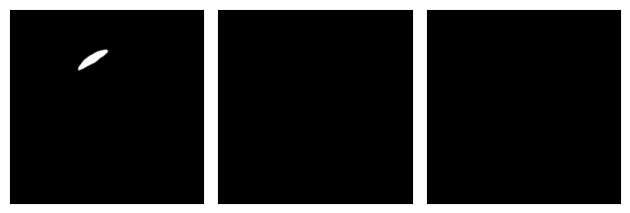

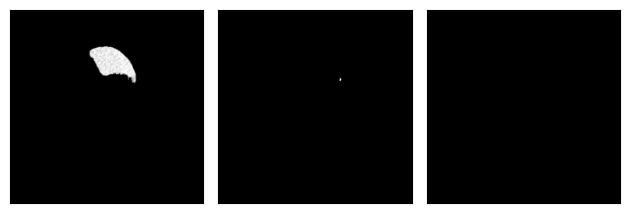

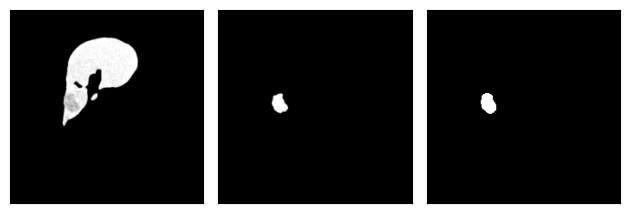

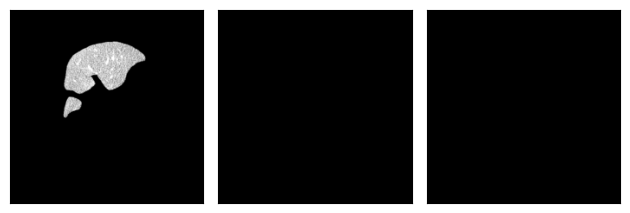

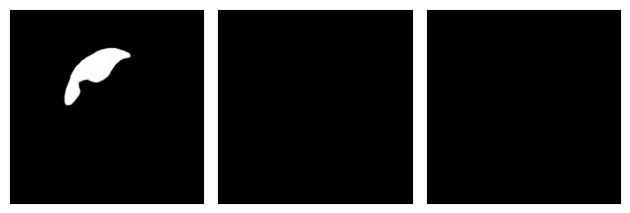

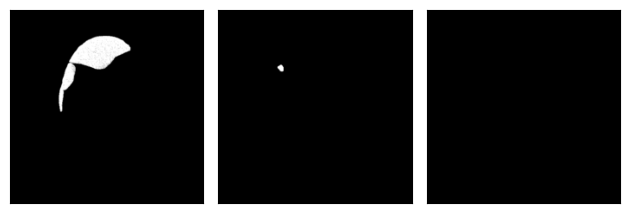

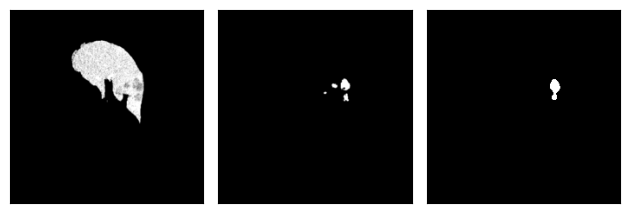

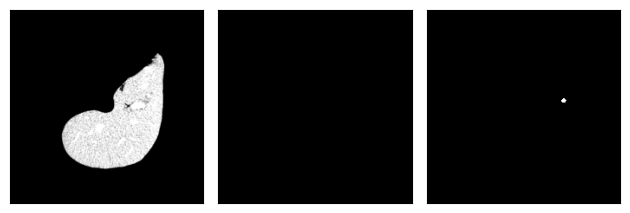

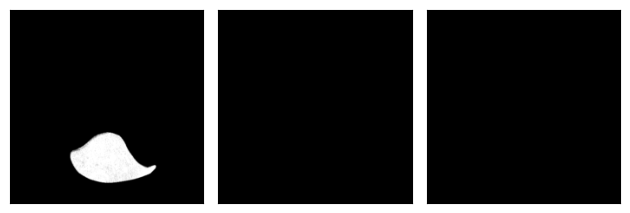

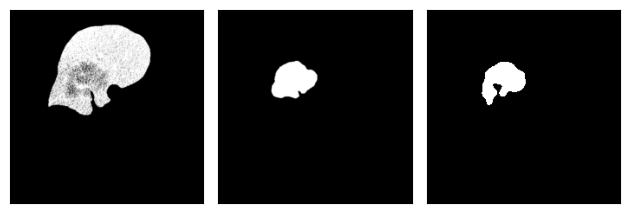

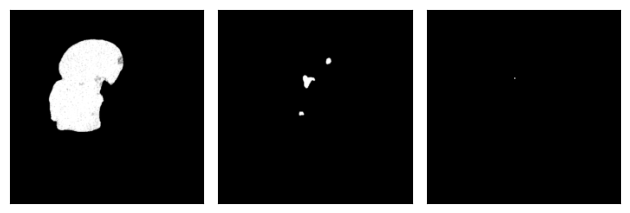

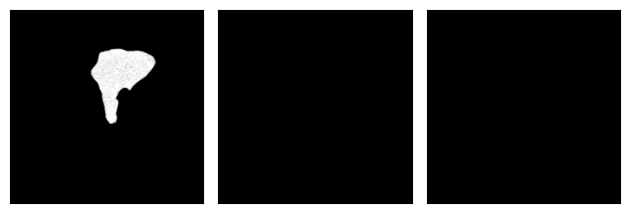

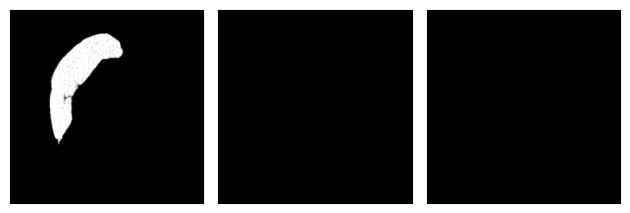

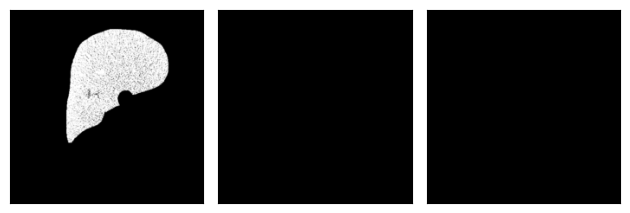

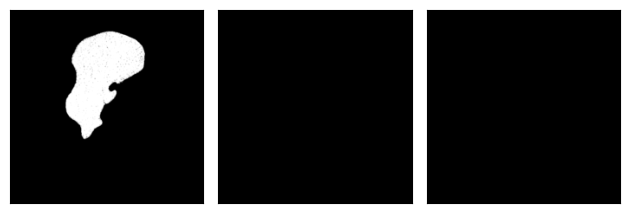

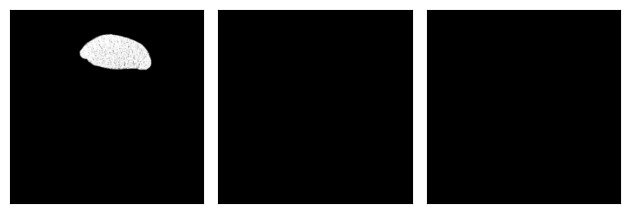

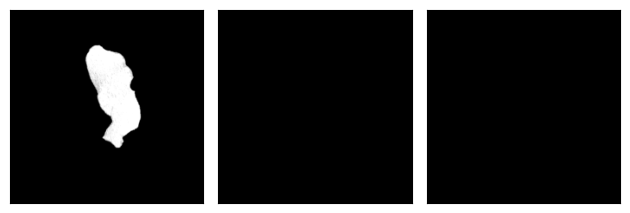

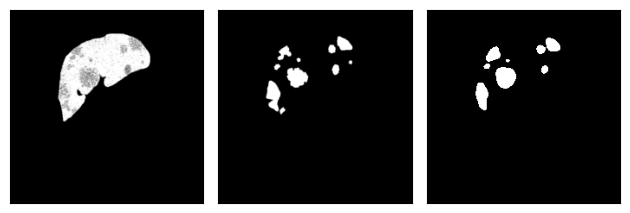

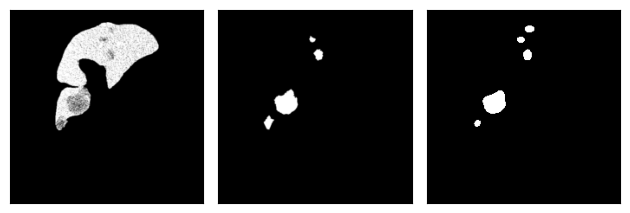

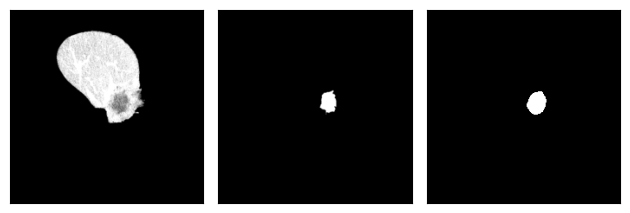

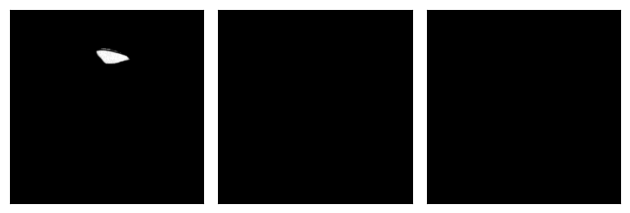

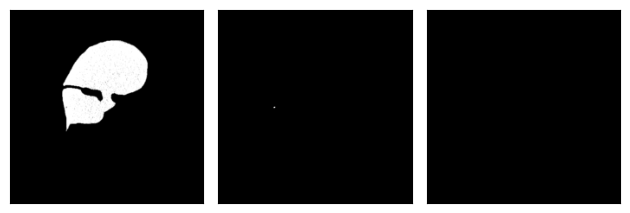

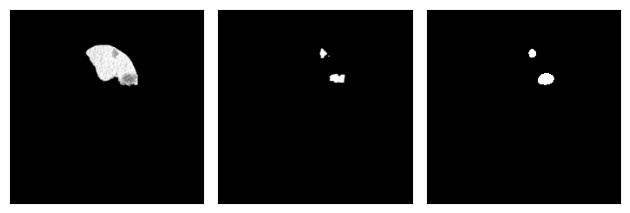

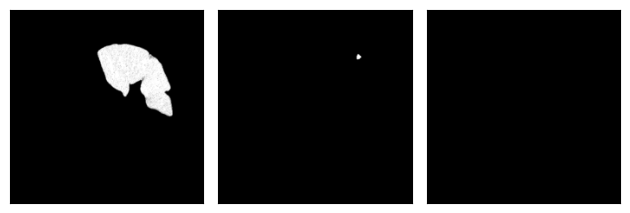

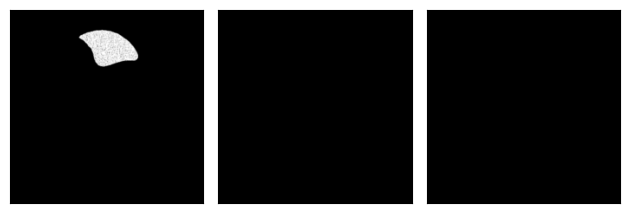

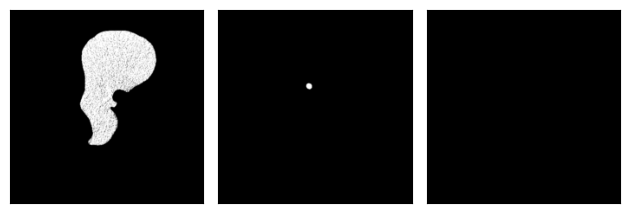

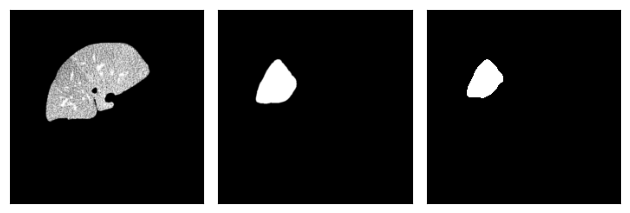

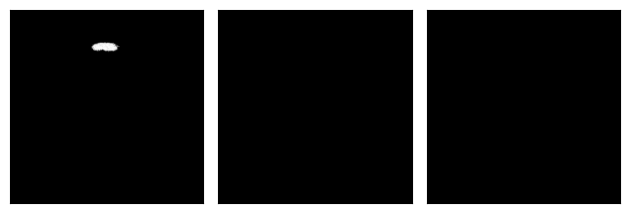

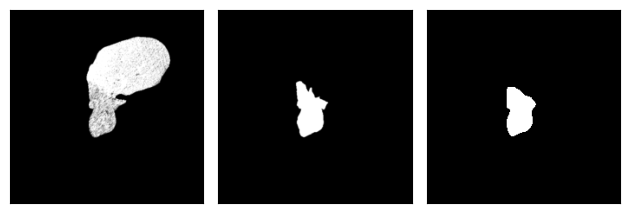

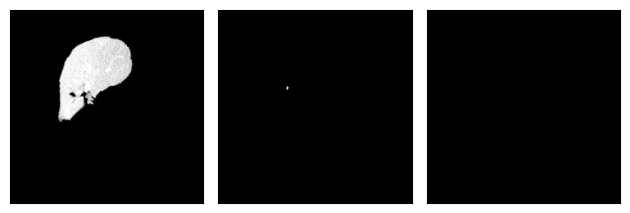

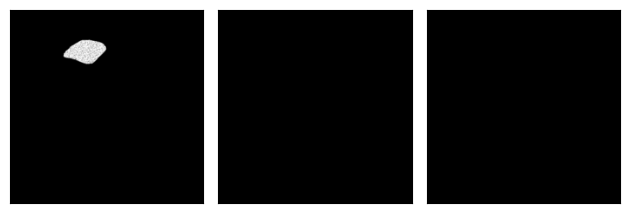

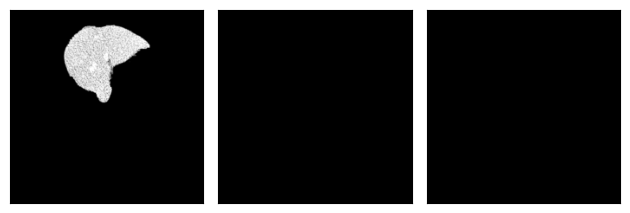

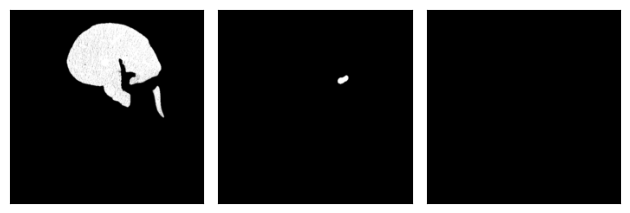

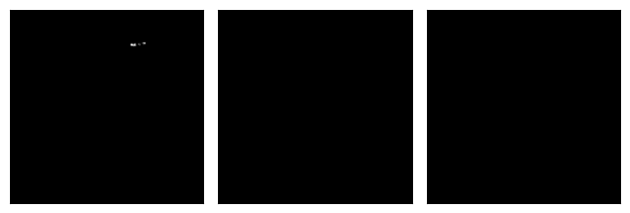

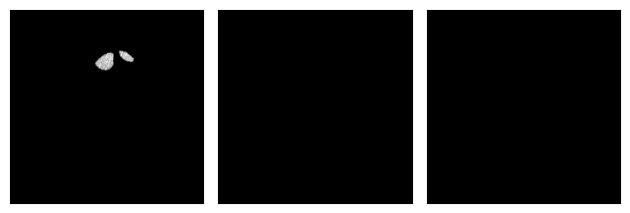

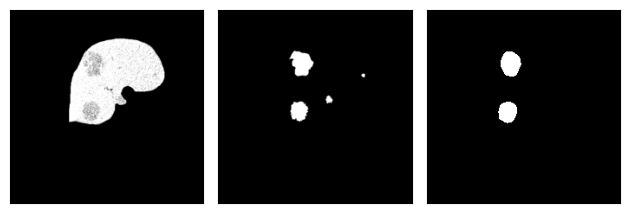

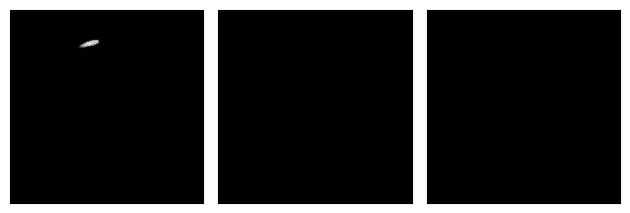

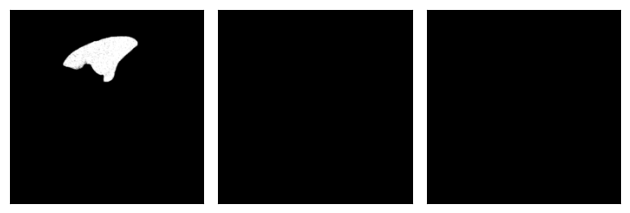

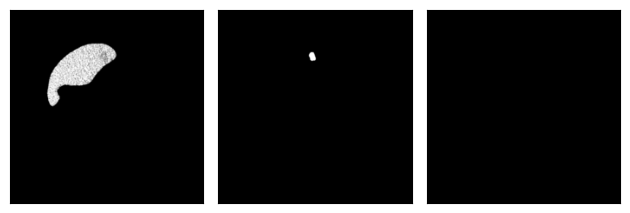

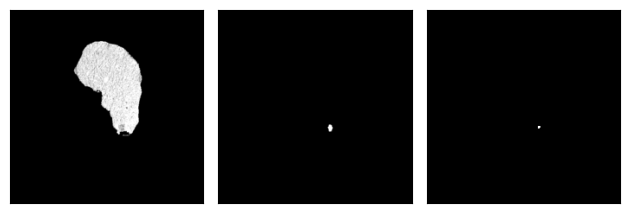

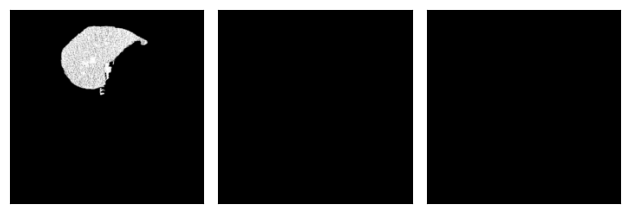

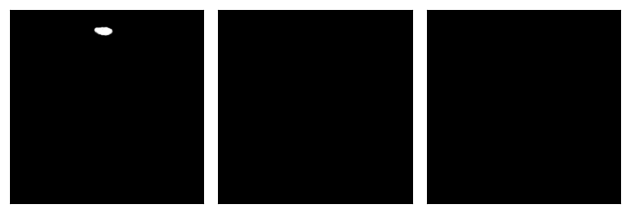

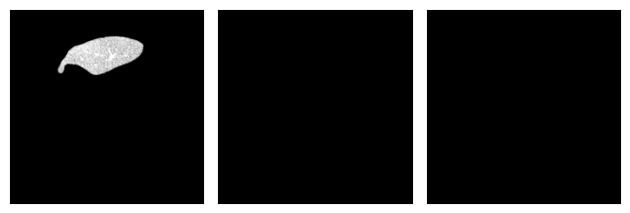

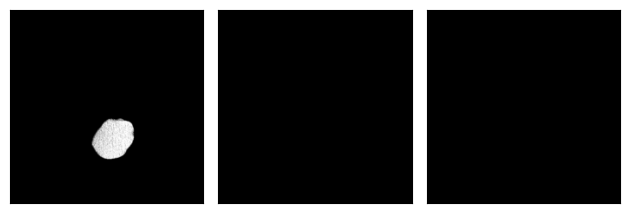

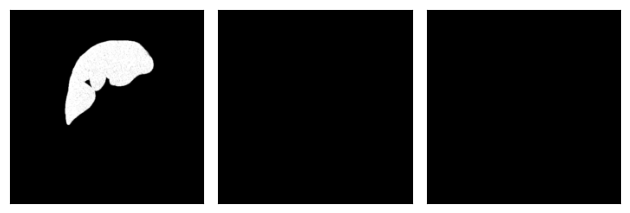

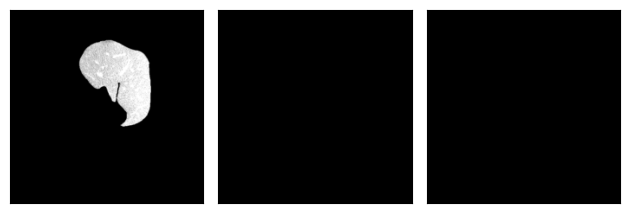

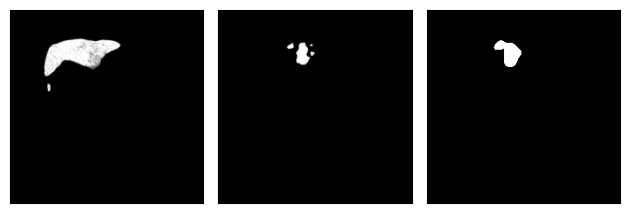

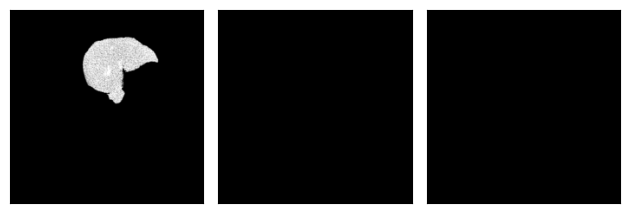

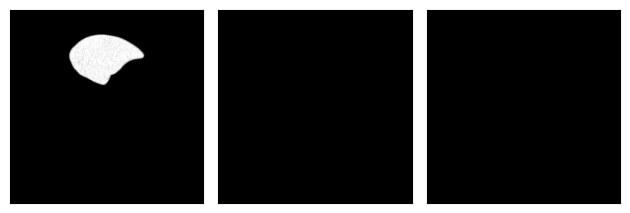

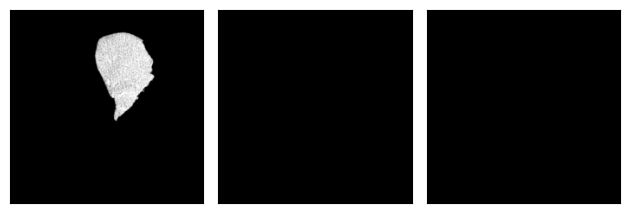

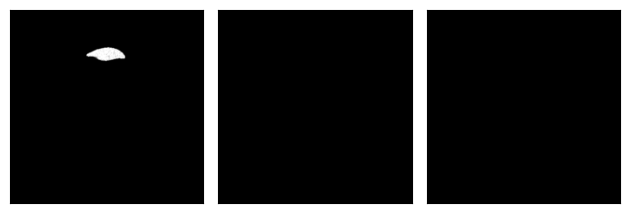

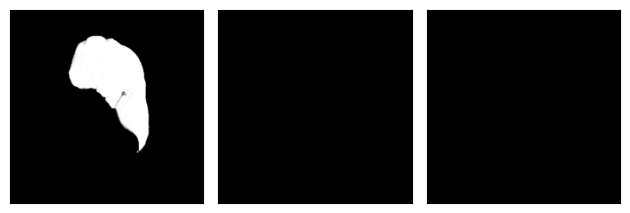

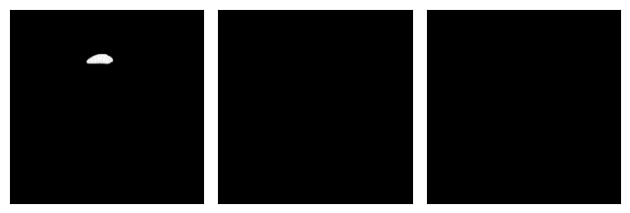

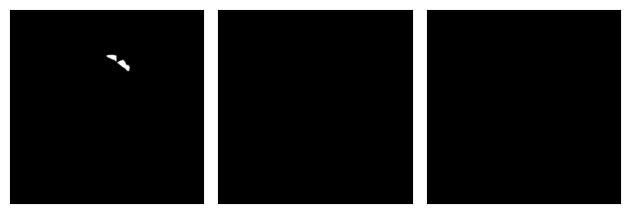

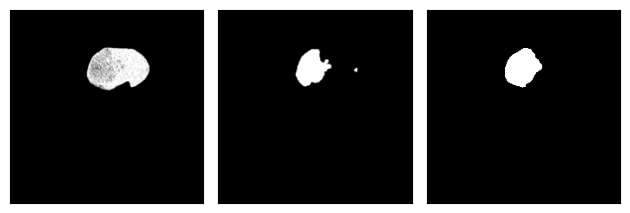

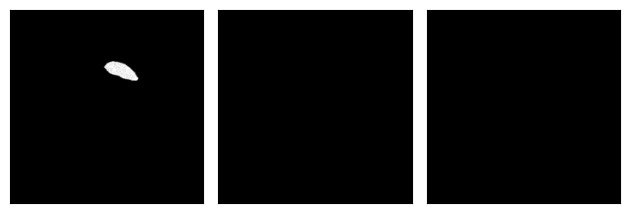

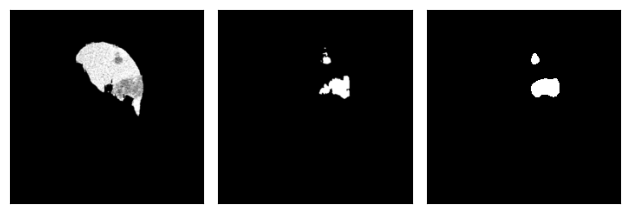

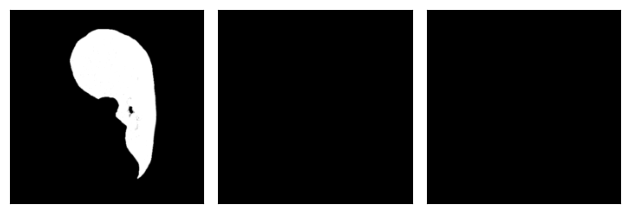

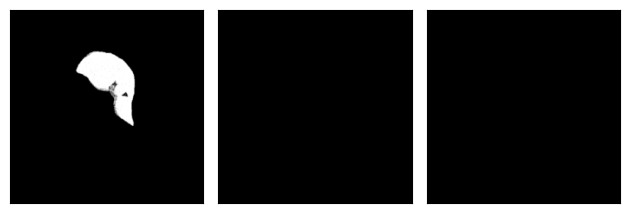

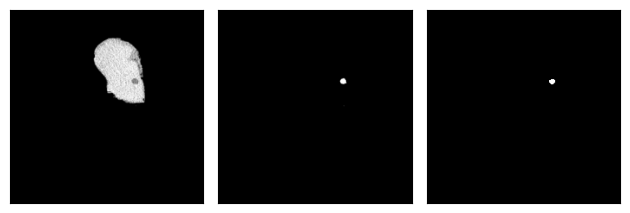

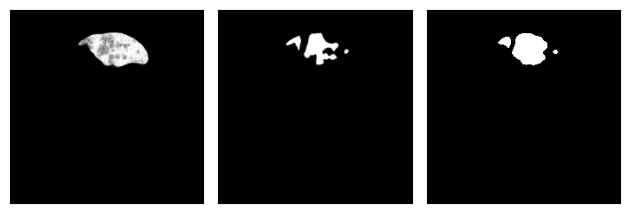

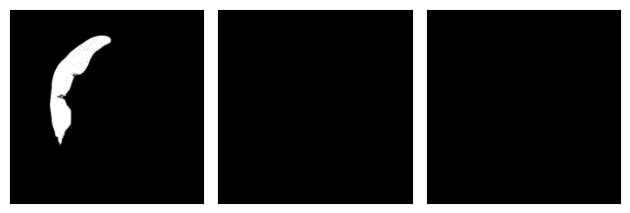

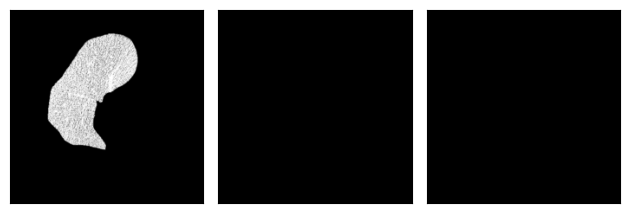

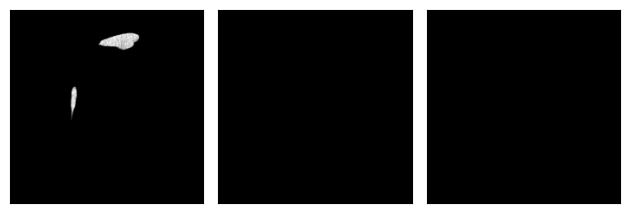

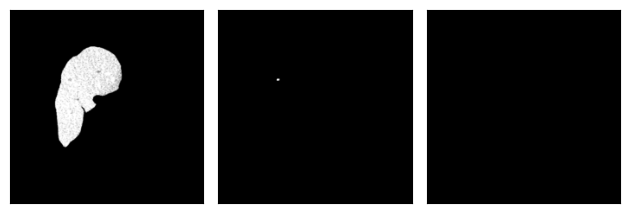

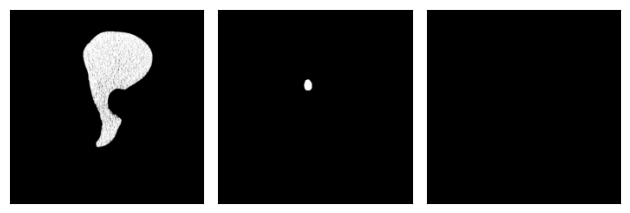

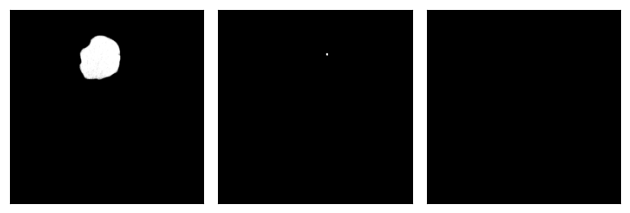

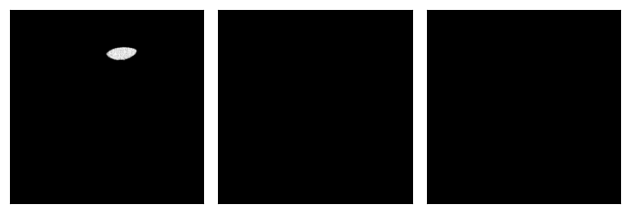

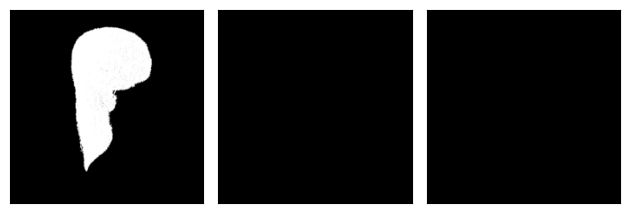

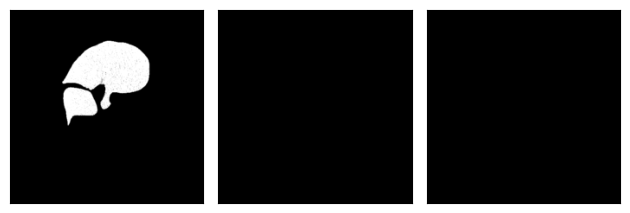

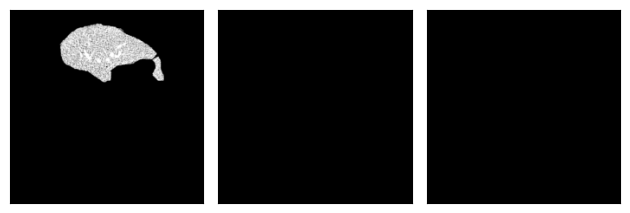

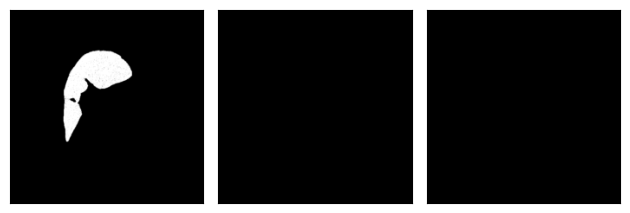

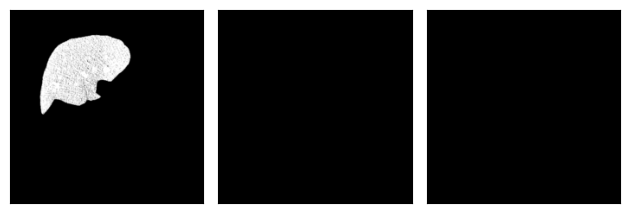

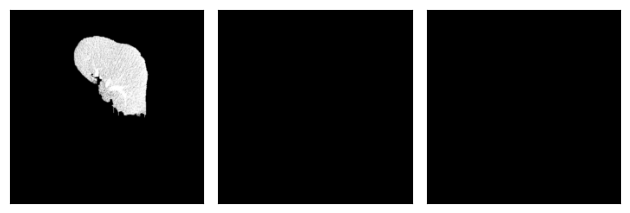

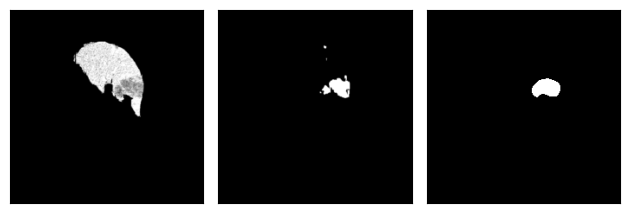

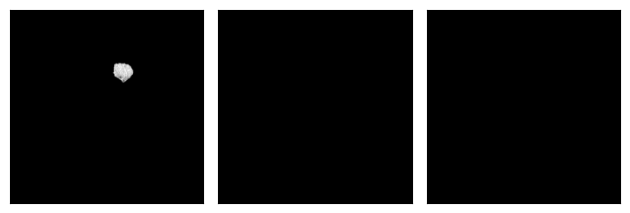

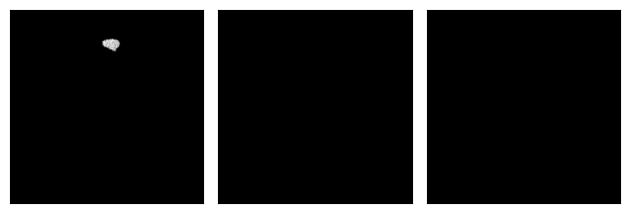

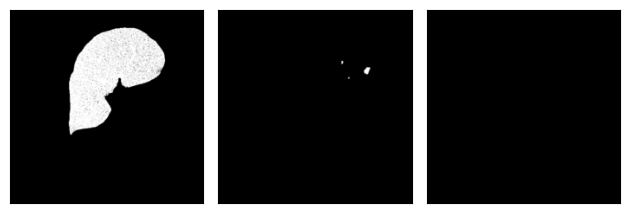

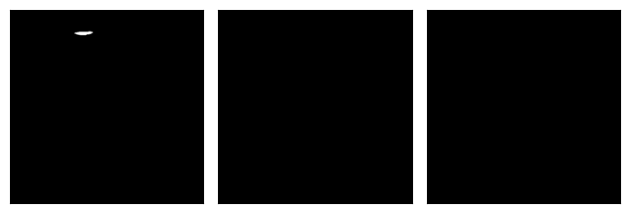

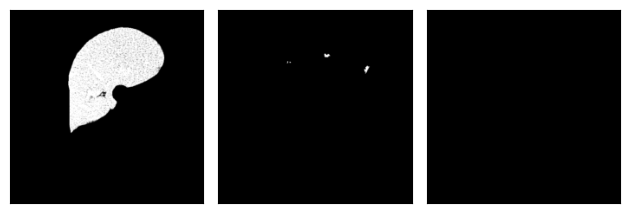

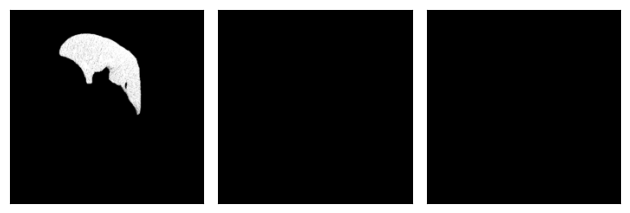

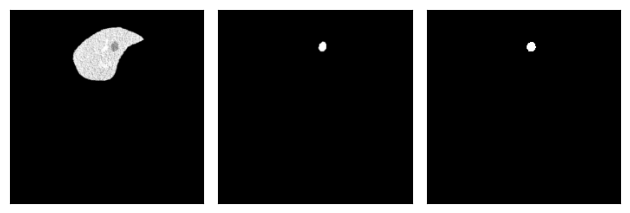

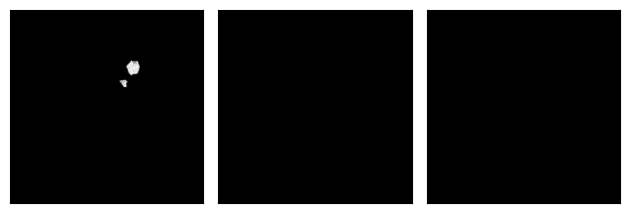

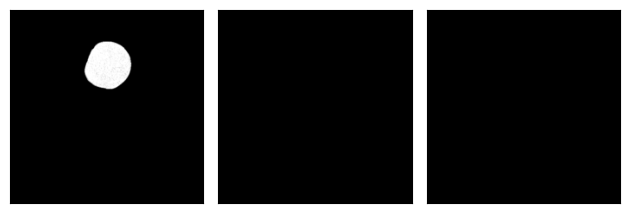

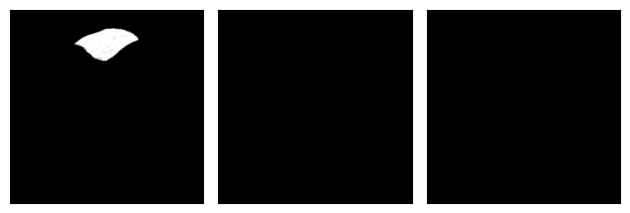

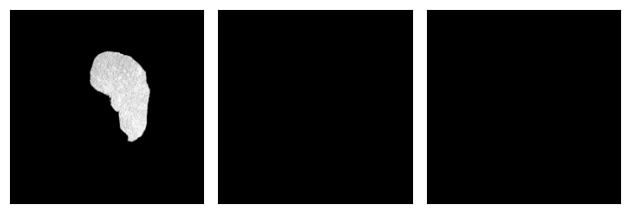

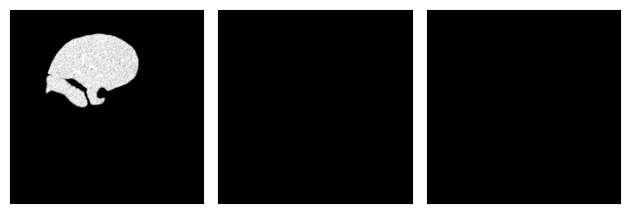

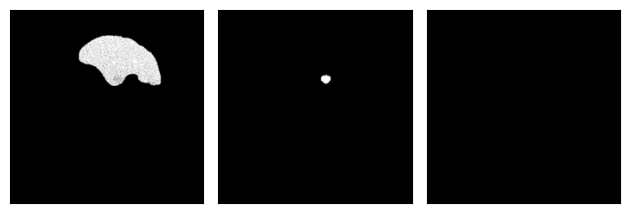

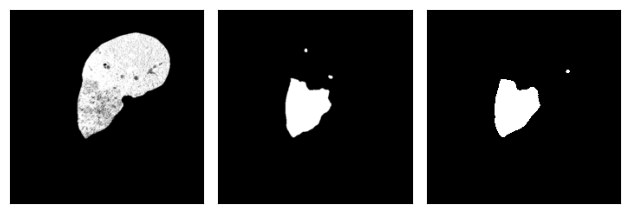

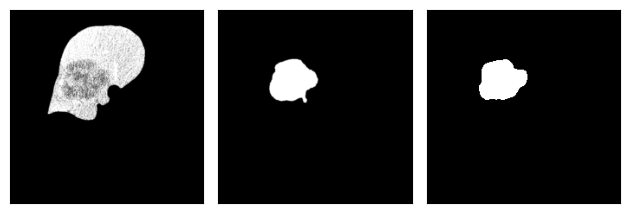

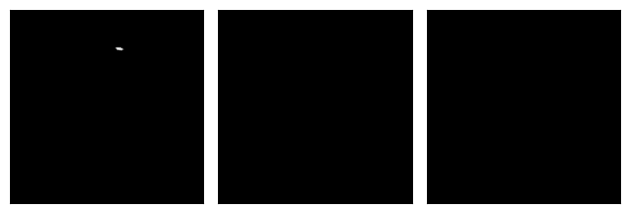

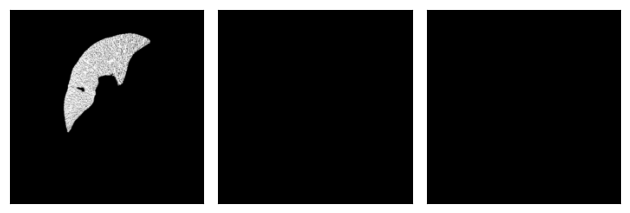

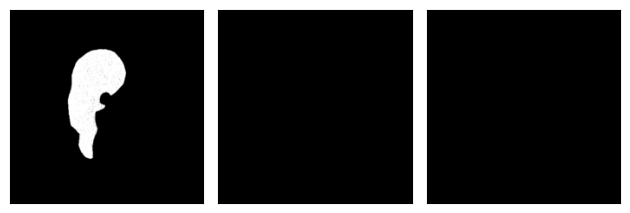

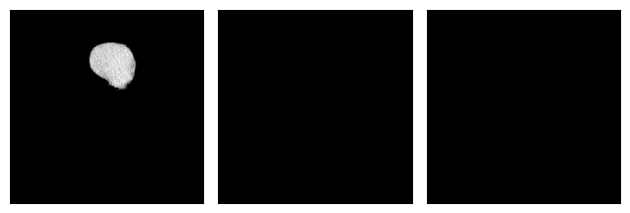

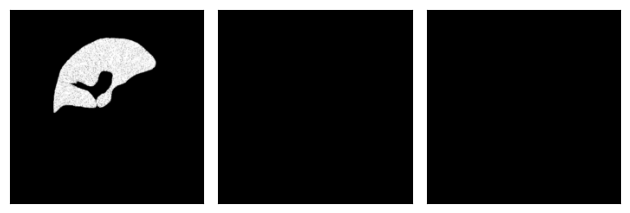

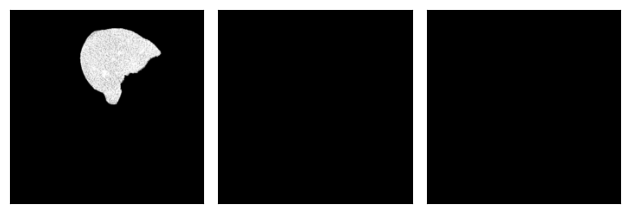

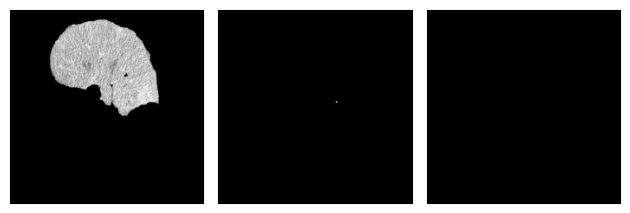

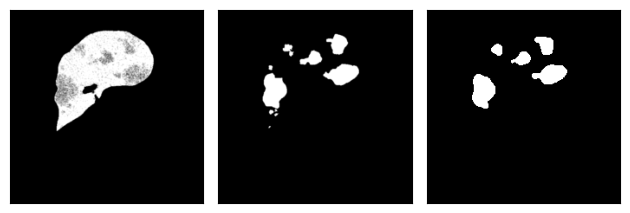

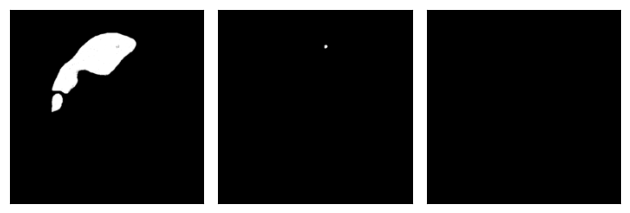

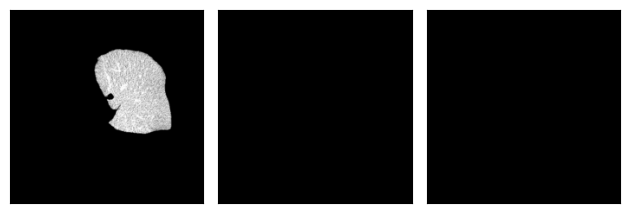

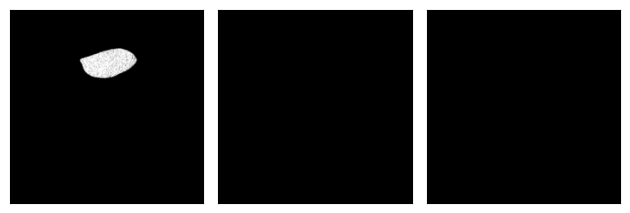

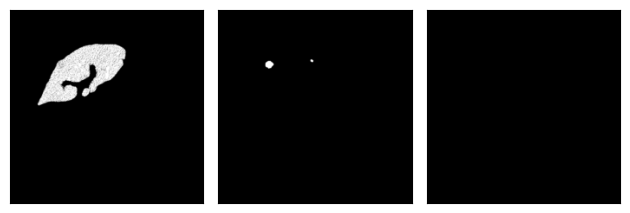

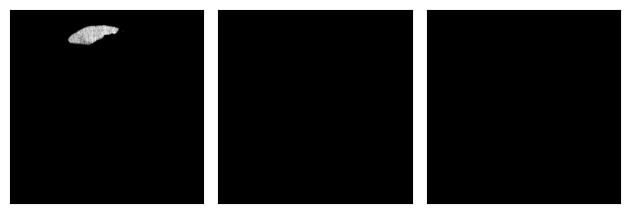

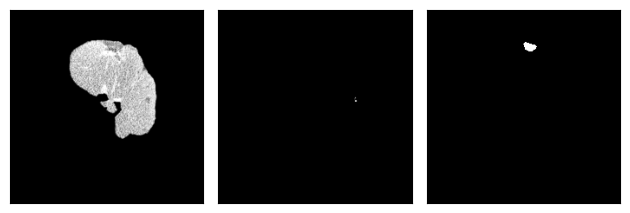

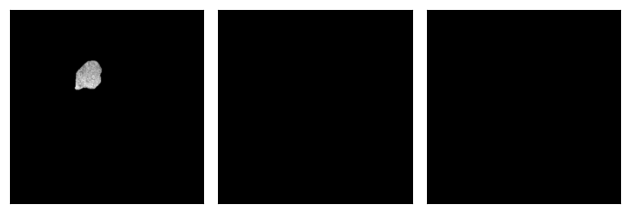

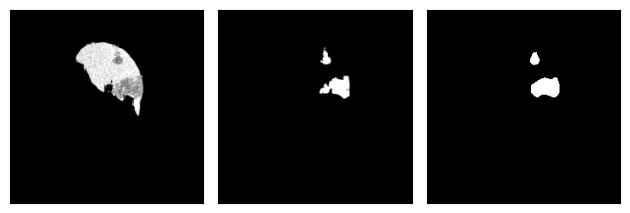

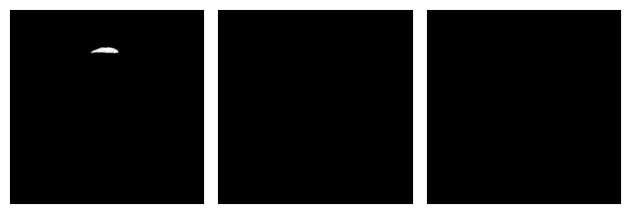

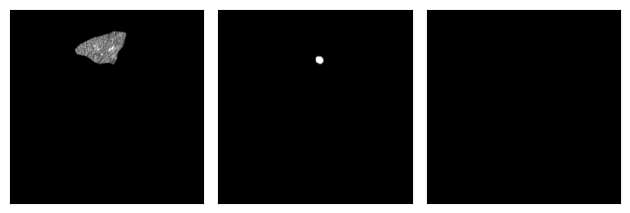

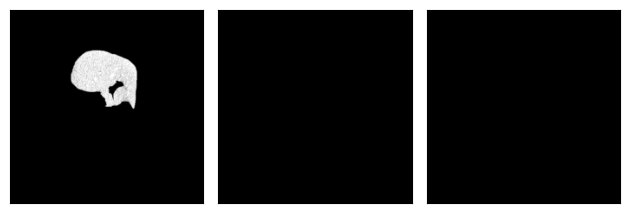

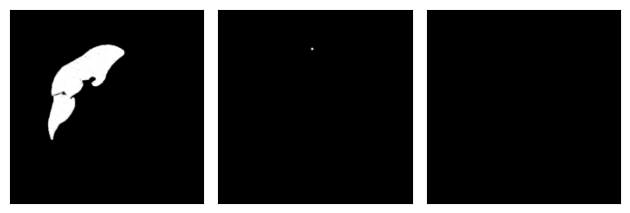

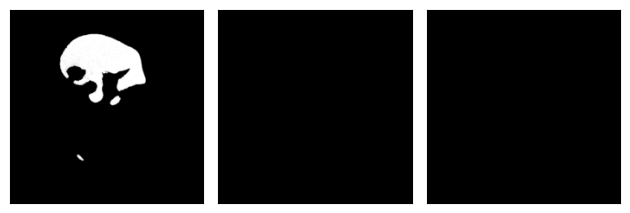

KeyboardInterrupt: 

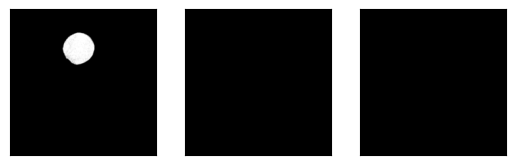

In [167]:
thresh = 0.99

for img, mask, pred in zip(images2, masks2, predictions2):
    plt.subplot(131)
    plt.imshow(img, cmap='gray')
    plt.xticks([]), plt.yticks([])
    plt.subplot(132)
    plt.imshow(mask, cmap='gray')
    plt.xticks([]), plt.yticks([])
    plt.subplot(133)
    plt.imshow(pred > thresh, cmap='gray')
    plt.xticks([]), plt.yticks([])
    plt.tight_layout()
    plt.show()